Importando as bibliotecas necessárias


In [91]:
import pandas as pd
import requests
import pdb
from plyer import notification
from datetime import datetime
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline


Conectando com a API

In [92]:
url = "https://restcountries.com/v3.1/all"
response = requests.get(url)

Criando uma função de alerta para o status da conexão

In [93]:
def alerta(codigo, base, etapa):
    now = datetime.now()
    formatted_now = now.strftime("%d/%m/%Y %H:%M:%S")

    msg = f"Status do carregamento da base {base} na etapa {etapa}.\n{formatted_now}"

    if response.status_code < 200 or response.status_code > 299:
        title = f'Erro na conexão com a API. Código status: {response.status_code}'
    else:
        title = f'Conexão com a API bem-sucedida. Código status: {response.status_code}'
        dados = response.json()
        df = pd.DataFrame(dados)

    notification.notify(
            title=title,
            message=msg,
            app_name='alerta',
            timeout=10
        )

alerta(codigo = response.status_code,
        base = url,
        etapa = "Importação API")

Função para realizar o deploy (salvar em arquivo CSV e banco de dados SQLite)


In [94]:
def deploy(df_formatado, destino_csv, destino_db):
    try:
        # Salvar o DataFrame em um arquivo CSV
        df_formatado.to_csv(destino_csv, index=False)
        alerta(codigo=200, base=destino_csv, etapa="Salvamento CSV")

        # Salvar o DataFrame em um banco de dados SQLite
        conn = sqlite3.connect(destino_db)
        df_formatado.to_sql('dados_formatados', conn, index=False, if_exists='replace')
        conn.close()
        alerta(codigo=200, base=destino_db, etapa="Salvamento SQLite")

    except Exception as e:
        alerta(codigo=500, base="Deploy", etapa="Erro no Salvamento")
        print(f"Erro no salvamento: {str(e)}")


Formando um Dataframe

In [95]:
if response.status_code >= 200 and response.status_code <= 299:
    dados = response.json()
    df = pd.DataFrame(dados)

    df_formatado = pd.DataFrame(dados)
    df_formatado['Nome'] = df_formatado['name'].apply(lambda x: x['common'])
    df_formatado['Mapa'] = df_formatado['maps'].apply(lambda x: x['googleMaps'])
    df_formatado['Região'] = df_formatado['region']
    df_formatado['População'] = df_formatado['population'].astype(float)  
    df_formatado['Área'] = df_formatado['area'].astype(float) 
    
    df_formatado['Idiomas'] = df_formatado['languages'].apply(lambda x: ', '.join(x.values()) if isinstance(x, dict) else 'N/A')
        
    df_formatado['Nome'] = df_formatado['Nome'].astype(str)
    df_formatado['Região'] = df_formatado['Região'].astype(str)
    df_formatado['Mapa'] = df_formatado['Mapa'].astype(str)
    
    colunas_selecionadas = ['Nome', 'Região', 'Mapa', 'População', 'Área', 'Idiomas']
    df_formatado = df_formatado[colunas_selecionadas]
    
    df_formatado
else:
    print("Erro na solicitação da API. Código de status:", response.status_code)

In [96]:
df_formatado


,Nome,Região,Mapa,População,Área,Idiomas
0,Andorra,Europe,https://goo.gl/maps/JqAnacWE2qEznKgw7,77265.0,468.0,Catalan
1,French Southern and Antarctic Lands,Antarctic,https://goo.gl/maps/6ua6CX1m4w1xF2Em7,400.0,7747.0,French
2,Laos,Asia,https://goo.gl/maps/F3asVB7sRKgSnwbE7,7275556.0,236800.0,Lao
3,Canada,Americas,https://goo.gl/maps/jmEVLugreeqiZXxbA,38005238.0,9984670.0,"English, French"
4,Nigeria,Africa,https://goo.gl/maps/LTn417qWwBPFszuV9,206139587.0,923768.0,English
...,...,...,...,...,...,...
245,American Samoa,Oceania,https://goo.gl/maps/Re9ePMjwP1sFCBFA6,55197.0,199.0,"English, Samoan"
246,Venezuela,Americas,https://goo.gl/maps/KLCwDN8sec7z2kse9,28435943.0,916445.0,Spanish
247,Costa Rica,Americas,https://goo.gl/maps/RFiwytjvNrpfKN7k6,5094114.0,51100.0,Spanish
248,Puerto Rico,Americas,https://goo.gl/maps/sygfDbtwn389wu8x5,3194034.0,8870.0,"English, Spanish"


Grafico de distribuição das regiões:

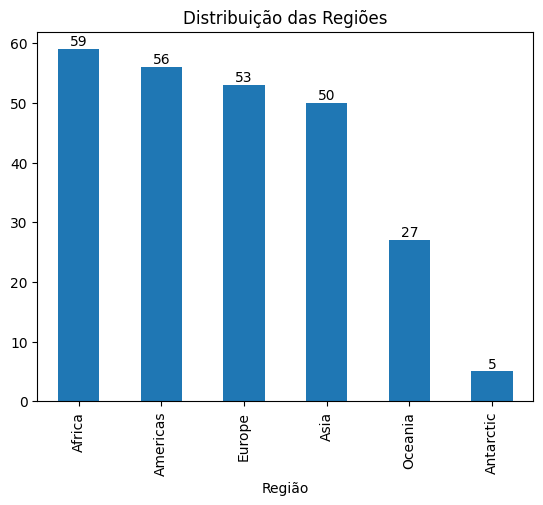

In [97]:
fig, ax = plt.subplots()
df_formatado['Região'].value_counts().plot(kind='bar', title='Distribuição das Regiões', ax=ax)

for i, v in enumerate(df_formatado['Região'].value_counts()):
     ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

Filtro de paises sem acesso ao mar:

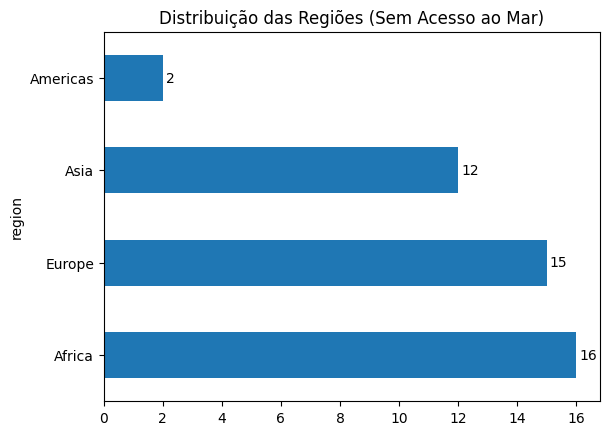

In [98]:
fig, ax = plt.subplots()
paises_sem_acesso_ao_mar['region'].value_counts().plot(kind='barh', title='Distribuição das Regiões (Sem Acesso ao Mar)', ax=ax)

    # Adicione rótulos para cada barra
for i, v in enumerate(paises_sem_acesso_ao_mar['region'].value_counts()):
    ax.text(v + 0.1, i, str(v), ha='left', va='center')  # Ajuste para barras horizontais

    # Exiba o gráfico
plt.show()


Função para deploy (salvar em um arquivo, banco de dados, etc.)


In [99]:
deploy(df_formatado, "dados_formatados.csv", "dados_formatados.db")